In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyfix import extract, classify, io
import os.path as op
from scipy import linalg, io as scio
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb

datadir = '../../tests/data/'

In [3]:
ica = scio.loadmat(f'{datadir}/FIXforMEG/labeledICs/ica_dsub-oxf001_task-resteyesclosed_meg.mat')['ica']

# IC time courses [time x numICs]
ic_timeseries = ica[0, 0]['tc']

# IC spatial maps [sensors x numICs]
ic_map = ica[0, 0]['sm']

# sampling rate
srate = ica[0, 0]['fsample'][0][0]

# EOG, EMG, ECG
eog = ica[0, 0]['EOG'].T
emg = ica[0, 0]['EMG'].T
ecg = ica[0, 0]['ECG'].T

# component labels
labels = ica[0, 0]['bad_components']
labels = np.array(labels)

from pyfix.extract import FixData, ICA, SpatialMap, TimeCourse

d = FixData(
    fixdir=f'{datadir}/fixmeg',
    ica=ICA(
        maps=SpatialMap(ic_map),
        timecourses=TimeCourse(ic_timeseries, fs=srate),
    ),
    timecourses={
        'eog': TimeCourse(eog, fs=srate),
        'ecg': TimeCourse(ecg, fs=srate),
        'emg': TimeCourse(emg, fs=srate),
    },
)

In [5]:
d, _ = extract.FixData.from_osl(
    fname=f'{datadir}/FIXforMEG/labeledICs/ica_dsub-oxf001_task-resteyesclosed_meg.mat', 
    fixdir=f'{datadir}/fixmeg',
)

In [6]:
from pyfix.feature import feature_extractor
from scipy import signal
import numpy as np

@feature_extractor
def spectral_slope(data, ic_idx):
    
    # get ic_timeseries
    ic_timeseries = data.ica.get_timecourse(ic_idx)
    fs = data.ica.srate
    
    # calc pwelch
    f, Pxx = signal.welch(ic_timeseries, fs, nfft=fs)
    
    # select freq > 7 Hz and < 70 Hz
    Pxx = Pxx[(f>=7) & (f<70)]
    f = f[(f>=7) & (f<70)]
    
    # fit linear line
    model = np.polyfit(f, Pxx, 1)

    return model[0]

@feature_extractor
def rms(data, ic_idx):
    
    # get ic_timeseries
    ic_timeseries = data.ica.get_timecourse(ic_idx)
    
    # calc rms
    rms = np.sqrt(np.mean(ic_timeseries**2))
    
    return rms

@feature_extractor
def eog_corr(data, ic_idx):
    
    # get ic_timeseries
    ic_timeseries = data.ica.get_timecourse(ic_idx)
    
    # get eog
    eog = data.timecourses['eog']
    
    # pearson correlation coefficient
    cc = [0] * eog.nchan
    for idx in np.arange(eog.nchan):
        cc[idx] = np.corrcoef(ic_timeseries, eog.get_timecourse(idx))[0, 1]
    
    return cc


f = extract.new_extract_features(
    data=d,
    features=['spectral_slope', 'rms', 'eog_corr']
)

print(f)

    spectral_slope         rms  eog_corr:0  eog_corr:1
0        -0.000397   17.108457    0.003943   -0.052725
1        -0.000485   14.089725   -0.003660    0.058653
2        -0.000743    4.911944    0.004013   -0.053286
3         0.036225  919.631777   -0.006527    0.059473
4        -0.000919   36.339865    0.008220   -0.062070
5        -0.000471   14.258775    0.002959   -0.055389
6        -0.000626    2.019293    0.025170   -0.056049
7        -0.000013    0.277590    0.019138   -0.018270
8        -0.000820    4.988424    0.010196   -0.057148
9        -0.000528   15.574368    0.005664   -0.063013
10       -0.000532   21.716154   -0.005672    0.058905
11       -0.000622    6.914712   -0.010705    0.061151
12       -0.000605    1.784426   -0.006941   -0.028578
13       -0.000476   10.585948    0.007179   -0.057099
14       -0.000778    6.484093   -0.007266    0.061987
15       -0.000526   11.830500   -0.007021    0.058422
16       -0.000447   14.644021    0.007586   -0.055503
17       -

# Create File Table

In [7]:
meg_files = glob.glob(f'{datadir}/FIXforMEG/labeledICs/*_meg.mat')

In [8]:
data = [op.abspath(f) for f in meg_files]
data

['/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf007_task-resteyesclosed_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf002_task-resteyesclosed_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf004_task-visuomotor_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf007_task-resteyesopen_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf002_task-resteyesopen_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf003_task-resteyesclosed_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf007_task-visuomotor_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf006_task-resteyesclosed_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf003_task-visuomotor_meg.mat',
 '/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf005_task-resteyesope

In [9]:
tbl = {
    'subid': [],
    'task': [],
    'data': data,
    'features': [],
    'labels': [],
}

for f in data:
    tbl['subid'] += [f.split('_')[1].split('-')[1]]
    tbl['task'] += [f.split('_')[2].split('-')[1]]
    tbl['features'] += [op.join(op.dirname(f), f"sub-{tbl['subid'][-1]}_task-{tbl['task'][-1]}.fixdir",'features.csv')]
    tbl['labels'] += [op.join(op.dirname(f), f"sub-{tbl['subid'][-1]}_task-{tbl['task'][-1]}.fixdir",'hand_labels.txt')]
    
tbl = pd.DataFrame(tbl)
tbl

subid            task                                               data  \
0   oxf007  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
1   oxf002  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
2   oxf004      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
3   oxf007    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
4   oxf002    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
5   oxf003  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
6   oxf007      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
7   oxf006  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
8   oxf003      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
9   oxf005    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
10  oxf004    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
11  oxf005      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
12  oxf005  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
13  oxf001      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
14  oxf003    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
15  oxf002      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
16  oxf006    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
17  oxf006      visuomotor  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
18  oxf001  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
19  oxf001    resteyesopen  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
20  oxf004  resteyesclosed  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   

                                             features  \
0   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
1   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
2   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
3   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
4   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
5   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
6   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
7   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
8   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
9   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
10  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
11  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
12  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
13  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
14  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
15  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
16  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
17  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
18  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
19  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   
20  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...   

                                               labels  
0   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
1   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
2   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
3   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
4   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
5   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
6   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
7   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
8   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
9   /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
10  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
11  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
12  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
13  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
14  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
15  /Users/seanf/dev/pyfix/tests/data/FIXforMEG/la...  
16  /Users/sean

# extract all features

In [11]:
for data, feature, label in zip(tbl['data'], tbl['features'], tbl['labels']):
    print(data)
    
    d0, labels0 = extract.FixData.from_osl(data, fixdir=op.dirname(feature))

    extract.new_extract_features(
        data=d0,
        features=['spectral_slope', 'rms', 'eog_corr'],
        feature_fname=feature,
    )
    
    np.savetxt(label, labels0.T, fmt='%i', delimiter=',')

/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf007_task-resteyesclosed_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf002_task-resteyesclosed_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf004_task-visuomotor_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf007_task-resteyesopen_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf002_task-resteyesopen_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf003_task-resteyesclosed_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf007_task-visuomotor_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf006_task-resteyesclosed_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf003_task-visuomotor_meg.mat
/Users/seanf/dev/pyfix/tests/data/FIXforMEG/labeledICs/ica_dsub-oxf005_task-resteyesopen_meg.mat
/Users/seanf/dev/pyfix/tests

# Train

Generate a `feature_table` that collates all the features from the files specified in the `file_table`.

In [12]:
training_data = classify.collate_features(tbl, legacy_features=False)
training_data.head()

spectral_slope         rms  eog_corr:0  eog_corr:1   group  label
0       -0.000216   81.287624   -0.072752   -0.139285  oxf007  False
1        0.005413  385.006853    0.073177    0.138668  oxf007  False
2        0.000667  167.514848    0.073241    0.139069  oxf007  False
3       -0.000727    9.184933   -0.072776   -0.140524  oxf007  False
4       -0.000454   39.555136   -0.073148   -0.138857  oxf007  False

In [13]:
from sklearn import svm, ensemble, neighbors, tree, neural_network as nn

# clf = classify.FixLegacyClassifier()
# clf = svm.SVC(probability=False, class_weight="balanced", gamma='scale', kernel='linear')
# clf = svm.SVC(probability=False, class_weight="balanced", gamma='scale', kernel='rbf')
clf = ensemble.RandomForestClassifier(n_estimators=50)
# clf = nn.MLPClassifier(solver='lbfgs', early_stopping=True)
# clf = ensemble.GradientBoostingClassifier()

clf, cm = classify.train(training_data, loo=True, clf=clf)


	TPR	TNR	(3*TPR+TNR)/4
Mean	99.68	92.70	97.94
Median	100.00	100.00	100.00
Pooled	99.68	95.00	98.51

Pooled confusion matrix:
[[1238    4]
 [   3   57]]


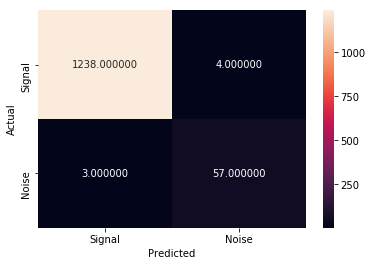

In [14]:
cm0 = np.sum(np.stack(cm, axis=2), axis=2)

sns.heatmap(cm0, annot=True, fmt='f')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.gca().set_xticklabels(['Signal', 'Noise'])
plt.gca().set_yticklabels(['Signal', 'Noise']);

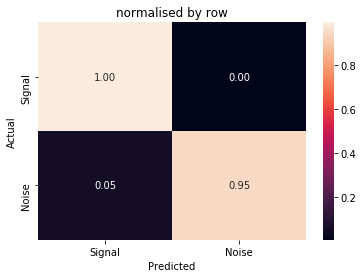

In [15]:
cm_norm = cm0 / np.sum(cm0, axis=1, keepdims=True)

sns.heatmap(cm_norm, annot=True, fmt='0.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('normalised by row')


plt.gca().set_xticklabels(['Signal', 'Noise'])
plt.gca().set_yticklabels(['Signal', 'Noise']);

# Classify (single subject)

Apply a trained model to classify the independent components from a single subject.

In [16]:
features0 = io.read_features(tbl.loc[0, 'features'])
    
Y = classify.classify(features0, clf)
Y = np.where(Y==1)[0]+1

print(Y)

[ 6 18 30 54]


In [17]:
labels0 = np.loadtxt(tbl.loc[0, 'labels'], delimiter=',', dtype=int)
labels0

array([ 6, 18, 30, 54])